In [1]:
import json
import pandas as pd
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import *
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import easydict
import sys
import re
import six
import math
import torchvision.transforms as transforms
from jamo import h2j, j2hcj, j2h

sys.path.append('./Whatiswrong')
sys.path.append('./Scatter')
import scatter_utils
import utils
import Trans
import Extract
import VFR
import SCR
import CTC
import en_dataset
import ko_dataset

In [211]:
import importlib
importlib.reload(scatter_utils)

<module 'scatter_utils' from './Scatter/scatter_utils.py'>

In [27]:
# opt
opt = easydict.EasyDict({
    "experiment_name" : 'scatter_0608',
    'saved_model' : 'scatter_0608/best_accuracy.pth',
    "imgH" : 35 ,"imgW" :  90,  'batch_size' : 64, 
    'character' : '0123456789ㄱㄲㄴㄷㄸㄹㅁㅂㅃㅅㅆㅇㅈㅉㅊㅋㅌㅍㅎㄵㄶㄺㄻㅀㄼㅄabcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣㅐㅒㅔㅖㅢㅟㅝㅞㅚㅘㅙ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' ,
    'batch_max_length' : 25,
    'output_channel' : 512, 'hidden_size' :256,
    'valinterval' : 100, 'num_epoch' : 300, 'input_channel' : 3,
    'n_scrb' : 2, 'scr_loss_lambda' : 1, 'ctc_loss_lambda' : 0.1,
    'lr' : 1, 'rho' : 0.95, 'eps' : 1e-8,
    'grad_clip' : 5,
    "manualSeed" : 1111, "PAD" : True ,'data_filtering_off' : True,'rgb' :True,'sensitive' : True, 'FT' : True,
    'num_fiducial' : 20,
    })
converter = utils.AttnLabelConverter(opt.character)
opt.num_classes = len(converter.character)
device = torch.device('cuda') #utils.py 안에 device는 따로 세팅해줘야함

In [3]:
ko_dataset = ko_dataset.dataset(num_samples = 100000)

100%|██████████| 100000/100000 [00:06<00:00, 16468.00it/s]


In [5]:
# KOREAN SYNTHETIC
kor_path = '/Data/FoodDetection/data/text_recognition/Korean/synthetic_data/data'

kor_images_labels = []
with open(os.path.join(kor_path, 'gt.txt'), 'r') as f:
    files = f.readlines()
    for idx, file in enumerate(files):
        img_path, label = file.split(' ')
        label = j2hcj(h2j(label.strip('\n')))
        img = Image.open(os.path.join(kor_path, f'{img_path}.jpg'))
        kor_images_labels.append([img, label])

In [6]:
# ENGLISH STR

# eng_dataset = en_dataset.get_english_dataset(opt) # 얘는 일단보류
eng_path = '/Data/FoodDetection/data/text_recognition/English/synthetic_oxford2'
file_list = os.listdir(eng_path)
eng_images_labels = []
for file in file_list[:300000]:
    try :
        img = Image.open(os.path.join(eng_path, file))
        label = file.split('_')[1].strip('\n')
        eng_images_labels.append([img, label])
        
    except Exception as e:
        print(e)
        continue
        

cannot identify image file '/Data/FoodDetection/data/text_recognition/English/synthetic_oxford2/77_heretical_35885.jpg'


In [7]:
ko_dataset.dataset.extend(kor_images_labels)
ko_dataset.dataset.extend(eng_images_labels)
random.shuffle(ko_dataset.dataset)
len(ko_dataset.dataset)

599999

In [20]:
# transform = get_transform()
dataset_streamer = utils.Dataset_streamer(ko_dataset.dataset[ : int(len(ko_dataset.dataset)*0.98)])
valid_streamer = utils.Dataset_streamer(ko_dataset.dataset[int(len(ko_dataset.dataset)*0.98) : ])

_AlignCollate = utils.AlignCollate(imgH=opt.imgH, imgW=opt.imgW, keep_ratio_with_pad=False)
data_loader = DataLoader(dataset_streamer, batch_size = opt.batch_size,  num_workers =0, shuffle=True, #worker_init_fn=worker_init_fn, 
                         collate_fn = _AlignCollate, pin_memory=False )
data_loader_iter = iter(data_loader)

#for valid
_AlignCollate_valid = utils.AlignCollate(imgH=opt.imgH, imgW=opt.imgW, keep_ratio_with_pad=True)
#not valid_streamer
valid_loader = DataLoader(valid_streamer, batch_size = opt.batch_size,  num_workers=0, shuffle=True, #worker_init_fn = worker_init_fn,
                          collate_fn=_AlignCollate_valid, pin_memory=False)
valid_loader_iter = iter(valid_loader)

In [10]:
img, label = next(data_loader_iter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


idx :  62


Text(0.5, 0, 'ㅎㅏㄱㅂㅜㅁㅗ')

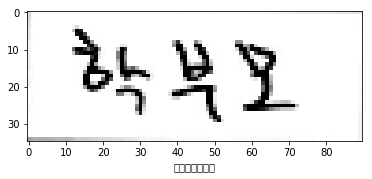

In [11]:
random_idx = np.random.choice(range(opt.batch_size), size=1)[0]
plt.imshow(img[random_idx].numpy().transpose().swapaxes(1,0))
print('idx : ',random_idx)
plt.xlabel(label[random_idx])

# model

In [193]:
text, length = converter.encode(label, batch_max_length = opt.batch_max_length)
img_tensor = img.to(device)

In [21]:
class SCATTER(nn.Module):
    def __init__(self, opt):
        super(SCATTER, self).__init__()
        self.opt = opt
        
        #Trans
        self.Trans = Trans.TPS_SpatialTransformerNetwork(F = opt.num_fiducial, i_size = (opt.imgH, opt.imgW), 
                                                  i_r_size= (opt.imgH, opt.imgW), i_channel_num=opt.input_channel, device = device)
        
        #Extract
        self.Extract = Extract.RCNN_extractor(opt.input_channel, opt.output_channel)
#         self.Extract = Extract.ResNet_FeatureExtractor(opt.input_channel, opt.output_channel)
        self.FeatureExtraction_output = opt.output_channel # (imgH/16 -1 )* 512
        self.AdaptiveAvgPool = nn.AdaptiveAvgPool2d((None,1)) # imgH/16-1   ->  1
            
        # VISUAL FEATURES 
        self.VFR = VFR.Visual_Features_Refinement(kernel_size = (3,1), num_classes = opt.num_classes, 
                                              in_channels = self.FeatureExtraction_output, out_channels=1, stride=1)
        
        
        # CTC DECODER
        self.CTC = CTC.CTC_decoder(opt.output_channel, opt.output_channel, opt.num_classes, opt, device)
            
        # Selective Contextual Refinement Block
        self.SCR_1 = SCR.Selective_Contextual_refinement_block(input_size = self.FeatureExtraction_output, 
                                                         hidden_size = int(self.FeatureExtraction_output/2),
                                                        output_size = self.FeatureExtraction_output,
                                                        num_classes = opt.num_classes, decoder_fix = False, device = device)
        
        self.SCR_2 = SCR.Selective_Contextual_refinement_block(input_size = self.FeatureExtraction_output, 
                                                         hidden_size = int(self.FeatureExtraction_output/2),
                                                        output_size = self.FeatureExtraction_output,
                                                        num_classes = opt.num_classes, decoder_fix = True, device = device)
  
    def forward(self, input, text, is_train=True):
        # Trans stage
        input = self.Trans(input)
        
        # Extract stage
        visual_feature = self.Extract(input) # visual_feature.shape) # (192, 512, 1 , 23)
        
        # Visual Feature Refinement
        visual_refined = self.VFR(visual_feature) # visual_ refined output Size([192, 23, 512])
        
        # CTC DECODER
        ctc_prob  = self.CTC(visual_refined, text, opt)
        
        #Selective Contextual Refinement
        scr_probs_1, H = self.SCR_1(visual_feature.permute(0, 3, 1, 2).squeeze(3), text, is_train)
        scr_probs_2, _ = self.SCR_2(H, text, is_train)
        
        return [scr_probs_1, scr_probs_2] ,ctc_prob
#         return [scr_probs_1, scr_probs_2] ,_
#         return _, ctc_prob
    

In [195]:
# scatter = SCATTER(opt)
# scatter = scatter.cuda()
# scr_probs, ctc_prob = scatter(img_tensor, text[:, 1:])

In [178]:
scatter

NameError: name 'scatter' is not defined

In [20]:
# print(len(scr_probs))
# print(ctc_prob.shape)
# ctc_loss

In [140]:
ctc_prob.shape

torch.Size([64, 23, 143])

In [141]:
text.shape

torch.Size([64, 27])

In [163]:
scatter.CTC.lstm.weight_ih_l0

Parameter containing:
tensor([[-0.0248,  0.0175, -0.0008,  ..., -0.0223,  0.0072, -0.0080],
        [ 0.0327,  0.0193, -0.0105,  ..., -0.0261, -0.0098, -0.0101],
        [-0.0112, -0.0440, -0.0057,  ...,  0.0378,  0.0394,  0.0340],
        ...,
        [ 0.0178, -0.0274, -0.0108,  ..., -0.0225,  0.0356,  0.0108],
        [ 0.0373, -0.0378,  0.0239,  ...,  0.0003, -0.0379,  0.0314],
        [ 0.0279, -0.0012,  0.0331,  ...,  0.0197, -0.0165, -0.0302]],
       device='cuda:0', requires_grad=True)

In [187]:
scatter.CTC.lstm.weight_ih_l0

Parameter containing:
tensor([[-0.0248,  0.0175, -0.0008,  ..., -0.0223,  0.0072, -0.0080],
        [ 0.0327,  0.0193, -0.0105,  ..., -0.0261, -0.0098, -0.0101],
        [-0.0112, -0.0440, -0.0057,  ...,  0.0378,  0.0394,  0.0340],
        ...,
        [ 0.0178, -0.0273, -0.0108,  ..., -0.0225,  0.0356,  0.0108],
        [ 0.0373, -0.0378,  0.0239,  ...,  0.0003, -0.0379,  0.0314],
        [ 0.0279, -0.0012,  0.0331,  ...,  0.0197, -0.0165, -0.0302]],
       device='cuda:0', requires_grad=True)

In [165]:
ctc_criterion = torch.nn.CTCLoss(blank= 0, reduction = 'mean', zero_infinity=True)

In [180]:
input_lengths = torch.full(size = (ctc_prob.size(0),), fill_value= ctc_prob.size(1), dtype=torch.long)
output_lengths = torch.randint(low = 1, high = ctc_prob.size(1), size = (ctc_prob.size(0), ), dtype = torch.long)
ctc_loss = ctc_criterion(ctc_prob.transpose(0,1), text[:, 1:], input_lengths, output_lengths)

In [181]:
ctc_loss

tensor(-1.6393, device='cuda:0', grad_fn=<MeanBackward0>)

In [183]:
ctc_loss.backward()

In [169]:
filtered_params = []
params_num = []
for p in filter(lambda p : p.requires_grad, scatter.parameters()):
    filtered_params.append(p)
    params_num.append(np.prod(p.size()))
print('Trainable params : ', sum(params_num))

Trainable params :  5804167


In [170]:
optimizer = optim.Adadelta(filtered_params, lr= opt.lr, rho = opt.rho, eps = opt.eps)

In [185]:
optimizer.step()

# train

In [25]:
def train(opt):
    
    model = SCATTER(opt)
    
    # WEIGHT INITIALIZATION
#     for name, param in model.named_parameters():
#         if 'localization_fc2' in name:
#             print(f'Skip {name} as it is already initializaed')
#             continue
            
#         try:
#             if 'bias' in name:
#                 init.constant_(param, 0.0)
#             elif 'weight' in name:
#                 init.kaiming_normal_(parm)
                
#         except Exception as e:
#             if 'weight' in name:
#                 param.data.fill_(1)
#             continue
    
#     print('layer SCR_1 initial weight :', model.SCR_1.BiLSTM_1.weight_ih_l0)
#     print('layer SCR_1 initial grad :', model.SCR_1.BiLSTM_1.weight_ih_l0.grad)
    
    # DATA PARALLEL
    model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)
#     model.to(device)
    model.train()
    
    # CHECK PRETRAINED MODEL
    if opt.saved_model!='':
        base_path = './models'
        try:
            if opt.FT:
                model.load_state_dict(torch.load(os.path.join(base_path, opt.saved_model)), strict=False)
            else :
                model.load_state_dict(torch.load(os.path.join(base_path, opt.saved_model)))
            print('got your model!')
        except Exception as e:
            print(f'Coudnt load model. error is {e}')
    
    # LOSS 
    scr_criterion = torch.nn.CrossEntropyLoss(ignore_index=0).to(device)
    ctc_criterion = torch.nn.CTCLoss(blank= 0, reduction = 'mean', zero_infinity=True).to(device)
    
    # Filter only require gradient descent
    filtered_params = []
    params_num = []
    for p in filter(lambda p : p.requires_grad, model.parameters()):
        filtered_params.append(p)
        params_num.append(np.prod(p.size()))
    print('Trainable params : ', sum(params_num))
    
    # OPTIMIZER
    optimizer = optim.Adadelta(filtered_params, lr= opt.lr, rho = opt.rho, eps = opt.eps)

    # OPT LOG
    with open(f'./models/{opt.experiment_name}/opt.txt', 'a') as opt_file:
        opt_log = '-----------------Options--------------------\n'
        args = vars(opt)
        for k, v in args.items():
            opt_log +=f'{str(k)} : {str(v)}\n'
        opt_log+= '--------------------------------------------\n' 
        opt_file.write(opt_log)
        
    # START TRAIN
    
    start_time = time.time()
    best_accuracy = -1
    best_norm_ED = -1
    
    for n_epoch, epoch in enumerate(range(opt.num_epoch)):
        for n_iter, data_point in enumerate(data_loader):
            images, labels = data_point
            images = images.to(device)
            text, length = converter.encode(labels, batch_max_length = opt.batch_max_length)
            
            batch_size = images.size(0)

            scr_probs, ctc_prob = model(images, text[:, 1:])
            target = text[:, 1:]

            losses = []
#             input_lengths = torch.full(size = (ctc_prob.size(0),), fill_value= ctc_prob.size(1), dtype=torch.long)
#             output_lengths = torch.randint(low = 1, high = ctc_prob.size(1), size = (ctc_prob.size(0), ), dtype = torch.long)
#             ctc_loss = ctc_criterion(ctc_prob.transpose(0,1), text[:, 1:], input_lengths, output_lengths)
            
#             losses.append(opt.ctc_loss_lambda * ctc_loss)
            for prob in scr_probs:
                scr_loss = scr_criterion(prob.view(-1, prob.shape[-1]), target.contiguous().view(-1))
                losses.append(opt.scr_loss_lambda * scr_loss)
            
            loss=0
            loss_avg = utils.Averager()
            for loss_ in losses:
                loss+=loss_
                loss_avg.add(loss_)

            model.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), opt.grad_clip)
            optimizer.step()
            
            #VALIDATION
            if n_iter % opt.valinterval ==0:
                elapsed_time = time.time() - start_time
                with open(f'./models/{opt.experiment_name}/log_train.txt' , 'a') as log:
                    model.eval()
                    with torch.no_grad():  #criterion arguments = ctc_criterion first
                        valid_loss, current_accuracy, current_norm_ED, preds, confidence_score, labels, infer_time, length_of_data = scatter_utils.validation(model, 
                        [ctc_criterion, scr_criterion], valid_loader, converter, opt)  
                    model.train()
                        
                    present_time = time.localtime()
                    loss_log = f'[epoch : {n_epoch}/{opt.num_epoch}] [iter : {n_iter*opt.batch_size} / {int(len(ko_dataset.dataset)*0.98)}]\n'+\
                    f'Train loss : {loss_avg.val():0.5f}, Valid loss : {valid_loss:0.5f}, Elapsed time : {elapsed_time:0.5f}, Present time : {present_time[1]}/{present_time[2]}, {present_time[3]+9} : {present_time[4]}'
                    loss_avg.reset()
                    
                    current_model_log = f'{"Current_accuracy":17s}: {current_accuracy:0.3f}, {"current_norm_ED":17s}: {current_norm_ED:0.2f}'
                    
                    #keep the best
                    if current_accuracy > best_accuracy:
                        best_accuracy = current_accuracy
                        torch.save(model.state_dict(), f'./models/{opt.experiment_name}/best_accuracy.pth')
                        
                    if current_norm_ED > best_norm_ED:
                        best_norm_ED = current_norm_ED
                        torch.save(model.state_dict(), f'./models/{opt.experiment_name}/best_norm_ED.pth')
                    
                    best_model_log = f'{"Best accuracy":17s}: {best_accuracy:0.3f}, {"Best_norm_ED":17s}: {best_norm_ED:0.2f}'
                    loss_model_log = f'{loss_log}\n{current_model_log}\n{best_model_log}'
                    print(loss_model_log)
                    log.write(loss_model_log+'\n')
                    
                    dashed_line = '-'*80
                    head = f'{"Ground Truth":25s} | {"Prediction":25s}|Confidence Score & T/F'
                    predicted_result_log = f'{dashed_line}\n{head}\n{dashed_line}\n'
                    
                    for gt, pred, confidence in zip(list(np.asarray(labels)[:5]), list(np.asarray(preds)[:5]), list(np.asarray(confidence_score)[:5])):
        
                        gt = gt[: gt.find('[s]')]
                        pred = pred[: pred.find('[s]')]
                        
                        predicted_result_log += f'{gt:25s} | {pred:25s} | {confidence:0.4f}\t{str(pred == gt)}\n'
                    predicted_result_log += f'{dashed_line}'
                    print(predicted_result_log)
                    log.write(predicted_result_log+'\n')
        
        if n_epoch % 10 ==0:
            torch.save(model.state_dict(), f'./models/{opt.experiment_name}/{n_epoch}.pth')
            

# main

In [ ]:
os.makedirs(f'./models/{opt.experiment_name}', exist_ok=True)

# set seed
random.seed(opt.manualSeed)
np.random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)
torch.cuda.manual_seed(opt.manualSeed)

# set GPU
cudnn.benchmark = True
cudnn.deterministic = True
opt.num_gpu = torch.cuda.device_count()

if opt.num_gpu > 1:
    print('-------Use multi GPU setting-------')
    opt.batch_size = opt.batch_size * opt.num_gpu
train(opt)

-------Use multi GPU setting-------
Trainable params :  37193125
[epoch : 0/300] [iter : 0 / 587999]
Train loss : 4.94733, Valid loss : 4.95421, Elapsed time : 0.87132, Present time : 6/8, 19 : 5
Current_accuracy : 0.000, current_norm_ED  : 0.01
Best accuracy    : 0.000, Best_norm_ED     : 0.01
--------------------------------------------------------------------------------
Ground Truth              | Prediction               |Confidence Score & T/F
--------------------------------------------------------------------------------
ㅂㅏㄹㅈㅓㄴㄷㅚㄷㅏ                | eeeeeeeeeeeeeeeeeeeeeeeee | 0.0000	False
ㅇㅠㅎㅏㄱ                     | eeeeeeeeeeeeeeeeeeeeeeeee | 0.0000	False
ㅇㅓㄹㅕㅇㅝㅈㅣㄷㅏ                | eeeeeeeeeeeeeeeeeeeeeeeee | 0.0000	False
admonishing               | eeeeeeeeeeeeeeeeeeeeeeeee | 0.0000	False
ㅅㅣㄹㅁㅏㅇ                    | eeeeeeeeeeeeeeeeeeeeeeeee | 0.0000	False
--------------------------------------------------------------------------------
